#<center>Classify MNIST Digits Using MLP</center>

In [ ]:
# importing some necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets, transforms
# from torchvision.transforms import ToTensor
# from torch.utils.data.sampler import SubsetRandomSampler

## Loading a Dataset

PyTorch provides a pre-built MNIST dataset in the "torchvision.datasets" module.

https://pytorch.org/tutorials/beginner/basics/data_tutorial.html


I load the MNIST Dataset with the following parameters:

- **root** is the path where the train/test data is stored,

- **train** specifies training or test dataset,

- **download=True** downloads the data from the internet if it’s not available at root.
- **transform** and **target_transform** specify the feature and label transformations.



In [ ]:
# Load the training and test datasets

# https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST

# from torchvision import datasets, transforms
train_dataset = datasets.MNIST(root='data', 
                               train=True, # If True, creates dataset from train-images-idx3-ubyte,
                               download=True, 
                               transform=transforms.ToTensor(),
                              #  target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
                               )

test_dataset = datasets.MNIST(root='data', 
                              train=False, # If False, creates dataset from t10k-images-idx3-ubyte.
                              download=True, 
                              transform=transforms.ToTensor(),
                              # target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
                              )

# Dataset Web Page link:
# http://yann.lecun.com/exdb/mnist/

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



## Iterating and Visualizing the Dataset

In [ ]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [ ]:
type(train_dataset)

torchvision.datasets.mnist.MNIST

In [ ]:
train_dataset[0][0].shape

torch.Size([1, 28, 28])

In [ ]:
type(train_dataset[1])

tuple

In [ ]:
print(f"Shape of one paricular Input data-point  is: {train_dataset[1][0].shape}")
print(f"label for this datapoint is: {train_dataset[1][1]}")

Shape of one paricular Input data-point  is: torch.Size([1, 28, 28])
label for this datapoint is: 0


In [ ]:
type(train_dataset[1][0])

torch.Tensor

In [ ]:
type(train_dataset[1][0][0])

torch.Tensor

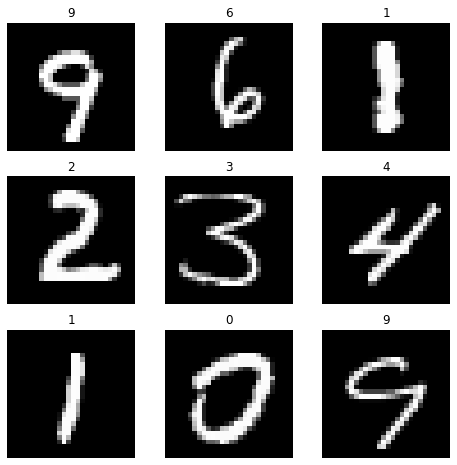

In [ ]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray") # squeezing remove all 1-D unless any specified "dim=i" is mentioned.
plt.show()

## Preparing your data for training with <U>'DataLoaders'</U>

In [ ]:
# create data loaders to batch and shuffle the data using the torch.utils.data.DataLoader class.

- The **'Dataset'** retrieves our dataset’s features and labels one sample at a time. 
 -   While training a model, we typically want to pass samples in **“minibatches”**, <U>reshuffle the data at every epoch to reduce model overfitting</U>, and use Python’s multiprocessing to speed up data retrieval.

In [ ]:
# "'DataLoader'" is an iterable that abstracts this complexity for us in an easy API.

In [ ]:
# Create data loaders to batch and shuffle the data

# from torch.utils.data import DataLoader

batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

## Iterate through the DataLoader

We have loaded that dataset into the **'DataLoader'** and can iterate through the dataset as needed.
- Each iteration below returns a batch of **train_features** and **train_labels** (containing **batch_size=64** features and labels respectively).
- Because we specified **shuffle=True**, after we iterate over all batches the data is shuffled (for finer-grained control over the data loading order, take a look at [Samplers](https://pytorch.org/docs/stable/data.html#data-loading-order-and-sampler).

In [ ]:
type(train_dataloader)

torch.utils.data.dataloader.DataLoader

In [ ]:
len(list(iter(train_dataloader)))

1875

In [ ]:
len(list(train_dataloader))

1875

Feature batch shape: torch.Size([32, 1, 28, 28])
Labels batch shape: torch.Size([32])


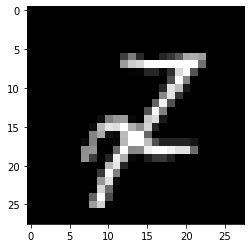

Label: 7


In [ ]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

## Define the Network Architecture:

* we need to define/create a model in such a way that it will accept input as a 784-dim Tensor of pixel values for each image, and it will produce a Tensor of length 10 (total number of classes) that indicates the class scores for an input image.
* Finally, output will belong to that class whose score is more.

**Get Device for Training:**

We want to be able to train our model on a hardware accelerator like the GPU, if it is available. Let’s check to see if torch.cuda is available, else we continue to use the CPU.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



**Define the Class**

In [ ]:
# Define the Neural Network Architecture
class Net_MNIST(nn.Module):
    def __init__(self):
        super(Net_MNIST, self).__init__()
        # linear layer (784 -> hidden_1)
        self.fc1 = nn.Linear(in_features=784, out_features=256, bias=True)   # 1st Hidden layer
        # linear layer (hidden_1 -> hidden_2)
        # self.fc2 = nn.Linear(512, 256)   # 2nd Hidden layer
        # self.fc3 = nn.Linear(256, 128)   # 3rd Hidden layer
        self.fc4 = nn.Linear(256, 64)    # 4th Hidden layer
        self.fc5 = nn.Linear(64, 10)  #output layer
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.dropout = nn.Dropout(0.2)
        self.dropout_2 = nn.Dropout(0.1)

    def forward(self, x):
        x = x.view(-1, 784)  # Flatten input image
        x = torch.relu(self.fc1(x))  # add hidden layer, with relu activation function
        x = self.dropout(x)  # add dropout layer
        # x = torch.relu(self.fc2(x))  # add hidden layer, with relu activation function
        # x = self.dropout(x)  # add output layer
        # x = torch.relu(self.fc3(x))  # add hidden layer, with relu activation function
        # x = self.dropout(x)  # add output layer
        x = torch.relu(self.fc4(x))  # add hidden layer, with relu activation function
        x = self.dropout_2(x)
        x = self.fc5(x) # add output layer
        return x


In [ ]:
# Instantiate the neural network model
model = Net_MNIST().to(device)
print(model)

Net_MNIST(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (dropout_2): Dropout(p=0.1, inplace=False)
)


###### Model Parameter

Many layers inside a neural network are parameterized, i.e. have associated weights and biases that are optimized during training.

Subclassing nn.Module automatically tracks all fields defined inside your model object, and makes all parameters accessible using your model’s ***parameters()*** or ***named_parameters() methods.***
- model.named_parameters()
- model.parameters()

In [ ]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")
    # break

Model structure: Net_MNIST(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (dropout_2): Dropout(p=0.1, inplace=False)
)


Layer: fc1.weight | Size: torch.Size([256, 784]) | Values : tensor([[-0.0161, -0.0004,  0.0172,  ..., -0.0156, -0.0017, -0.0214],
        [-0.0041, -0.0013, -0.0026,  ..., -0.0137, -0.0050,  0.0226]],
       grad_fn=<SliceBackward0>) 

Layer: fc1.bias | Size: torch.Size([256]) | Values : tensor([ 0.0318, -0.0258], grad_fn=<SliceBackward0>) 

Layer: fc4.weight | Size: torch.Size([64, 256]) | Values : tensor([[ 0.0309, -0.0413,  0.0265,  0.0625, -0.0353,  0.0164, -0.0233,  0.0117,
         -0.0506,  0.0174, -0.0542, -0.0304, -0.0159, -0.0330, -0.0121, -0.0282,
          0.0212, -0.0116,  0.0432,  0.0030, -0.0351,  0.0516,  0.0316, -0.0086,
         -0.0486, -0.0300,  0.0423,  0.0465,  0.052

In [ ]:
# list(model.parameters())

Analyze any Random Image:)

In [ ]:
print(device)

cpu


In [ ]:
# Check if the model is on CPU or CUDA
if next(model.parameters()).is_cuda:
    print('Model is on CUDA')
else:
    print('Model is on CPU')

Model is on CPU


logits is: 
tensor([[ 0.0851, -0.0892, -0.0084, -0.0526,  0.0799, -0.1269, -0.0849,  0.0252,
          0.0806,  0.0816]], grad_fn=<AddmmBackward0>)


pred_probab is: tensor([[0.1087, 0.0913, 0.0990, 0.0947, 0.1081, 0.0879, 0.0917, 0.1023, 0.1082,
         0.1083]], grad_fn=<SoftmaxBackward0>)
Predicted class: tensor([0])


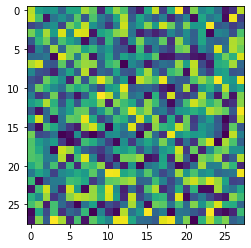

In [ ]:
X_ = torch.rand(1, 28, 28, device=device)
# # Move tensor to CPU memory and convert to Numpy array
# X = X_.cpu().numpy()
logits = model(X_)
print(f"logits is: \n{logits}\n\n")
pred_probab = nn.Softmax(dim=1)(logits)   # "dim" parameter indicates the dimension along which the values must sum to 1
print(f"pred_probab is: {pred_probab}")
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")
X = X_.cpu().numpy()
plt.imshow(X.squeeze())
plt.show()

https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

##### Hyperparameters

- Hyperparameters are adjustable parameters that let you control the model optimization process. 
- Different hyperparameter values can impact model training and convergence rates.


We define the following hyperparameters for training:

- **Number of Epochs** - the number times to iterate over the dataset

- **Batch Size** - the number of data samples propagated through the network before the parameters are updated

- **Learning Rate** - how much to update models parameters at each batch/epoch. Smaller values yield slow learning speed, while large values may result in unpredictable behavior during training.



In [ ]:
learning_rate = 1e-3
batch_size = 64
epochs = 20

#### Optimization Loop
Once we set our hyperparameters, we can then train and optimize our model with an optimization loop. Each iteration of the optimization loop is called an ***epoch.***
- Loss Function
- Optimizer


Each epoch consists of two main parts:

- **The Train Loop** - iterate over the training dataset and try to converge to optimal parameters.
- **The Validation/Test Loop** - iterate over the test dataset to check if model performance is improving.



##### Loss Function

**Loss function** measures the degree of dissimilarity of obtained result to the target value, and it is the loss function that we want to minimize during training. 

To calculate the loss we make a prediction using the inputs of our given data sample and compare it against the true data label value.

Common loss functions include [**nn.MSELoss**](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss) (Mean Square Error) for regression tasks, and [**nn.NLLLoss**](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html#torch.nn.NLLLoss) (Negative Log Likelihood) for classification. [**nn.CrossEntropyLoss**](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss) combines ***nn.LogSoftmax*** and ***nn.NLLLoss.***

In [ ]:
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

##### Optimizer

Optimization is the process of adjusting model parameters to reduce model error in each training step. 

**Optimization algorithms** define how this process is performed (in this example we use Stochastic Gradient Descent).

There are many [different optimizers](https://pytorch.org/docs/stable/optim.html) available in PyTorch such as ADAM and RMSProp, that work better for different kinds of models and data.

**We initialize the optimizer by registering the model’s parameters that need to be trained, and passing in the learning rate hyperparameter.**

In [ ]:
# We initialize the optimizer by registering the model’s parameters that need to be trained, and passing in the learning rate hyperparameter.
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Inside the training loop, optimization happens in three steps:
* Call **optimizer.zero_grad()** to reset the gradients of model parameters. Gradients by default add up; to prevent double-counting, we explicitly zero them at each iteration.
* Backpropagate the prediction loss with a call to **loss.backward()**. PyTorch deposits the gradients of the loss w.r.t. each parameter.
* Once we have our gradients, we call **optimizer.step()** to adjust the parameters by the gradients collected in the backward pass.

In [ ]:
# OHE (One Hot Encoding)
# from torchvision.transforms import Lambda # ToTensor, Lambda

# target_transform = Lambda(lambda y: torch.zeros(
#     10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))

## Defining the Training and Testing Function

In [ ]:
from tqdm import tqdm

def train(model, device, train_loader, optimizer, loss_fn):
    model.train()
    epoch_loss = 0.0
    with tqdm(total=len(train_loader)) as progress_bar:
        for i, (inputs, labels) in enumerate(train_loader, 0):
            inputs, labels = inputs.to(device), labels.to(device)

            # Compute prediction and loss
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            progress_bar.update(1)

    avg_epoch_loss = epoch_loss / len(train_loader)
    return avg_epoch_loss


Here's a step-by-step explanation of the code:

1. **size = len(dataloader.dataset) :** This line initializes a variable size to the total number of samples in the dataset.

2. **model.train() :** This sets the model to training mode. This is necessary because the behavior of some layers in the model (such as dropout or batch normalization) can differ between training and inference, and setting the model to training mode ensures that these layers behave correctly during training.

3.  **for batch, (X, y) in enumerate(dataloader): :** This is a loop that iterates over the batches of the input data. X and y are the input features and labels of the current batch.

4. **X, y = X.to(device), y.to(device) :** This moves the input data and labels to the device (CPU or GPU) that the model is currently on.

5. **pred = model(X) :** This computes the model's predictions for the current batch of input data.

6. **loss = loss_fn(pred, y) :** This computes the loss between the model's predictions and the ground-truth labels.

7. **optimizer.zero_grad() :** This clears the gradients of all optimized tensors. This is necessary because PyTorch accumulates gradients by default.

8. **loss.backward() :** This computes the gradients of the loss with respect to all optimized tensors.

9. **optimizer.step() :** This updates the optimized tensors based on their gradients.

10. **if batch % 100 == 0:** : This condition checks if the current batch is a multiple of 100.

11. **loss, current = loss.item(), batch * len(X) :** This line assigns the current loss to the variable loss and computes the index of the current sample.

12. **print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]") :** This prints the current loss and the progress of the training.


Finally, regarding **model.train()**, it is only called once at the beginning of the function to ensure that the model is in training mode before the training loop begins. It is not necessary to call it again inside the loop.

In [ ]:
def test(model, device, test_loader, loss_fn):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad(), tqdm(total=len(test_loader)) as progress_bar:
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            test_loss += loss_fn(outputs, labels).item() * labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            progress_bar.update(1)

    avg_test_loss = test_loss / len(test_loader.dataset)
    accuracy = 100 * correct / total
    return avg_test_loss, accuracy


**Here is a step-by-step explanation of the test function:**

-   **size = len(dataloader.dataset):** Get the size of the dataset by getting the length of the dataloader's dataset attribute.
-    **num_batches = len(dataloader):** Get the number of batches by getting the length of the dataloader.
-    **model.eval():** Set the model to evaluation mode. This is necessary because some layers in the model behave differently during training and evaluation (e.g., dropout or batch normalization).
-    **test_loss, correct = 0, 0:** Initialize the test loss and number of correct predictions to 0.
-    **with torch.no_grad()::** Enter a block where PyTorch won't track the gradients. This speeds up computation and saves memory.
-   **for X, y in dataloader::** Iterate over the batches in the dataloader.
-    **X, y = X.to(device), y.to(device):** Move the input data and target labels to the device (e.g., CPU or GPU) being used for computation.
-   **pred = model(X):** Get the model's predictions for the input data.
-   **test_loss += loss_fn(pred, y).item():** Calculate the loss of the predictions and add it to the running total of test loss.
-    **correct += (pred.argmax(1) == y).type(torch.float).sum().item():** Count the number of correct predictions and add it to the running total of correct predictions.
-   **test_loss /= num_batches:** Calculate the average test loss over all batches.
-    **correct /= size:** Calculate the accuracy by dividing the number of correct predictions by the size of the dataset.
-   **print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n"):** Print the test error, including the accuracy and average loss.

## Training the Model and Evaluating Performance

100%|██████████| 313/313 [00:01<00:00, 190.58it/s]


Epoch [1/30], train_loss: 2.2672, test_loss: 2.2190, accuracy: 41.99%


100%|██████████| 313/313 [00:02<00:00, 126.13it/s]


Epoch [2/30], train_loss: 2.1438, test_loss: 2.0180, accuracy: 50.08%


100%|██████████| 313/313 [00:01<00:00, 191.20it/s]


Epoch [3/30], train_loss: 1.8437, test_loss: 1.5799, accuracy: 63.82%


100%|██████████| 313/313 [00:01<00:00, 187.98it/s]


Epoch [4/30], train_loss: 1.3725, test_loss: 1.0920, accuracy: 76.48%


100%|██████████| 313/313 [00:03<00:00, 88.78it/s] 


Epoch [5/30], train_loss: 1.0086, test_loss: 0.8088, accuracy: 80.90%


100%|██████████| 313/313 [00:01<00:00, 190.03it/s]


Epoch [6/30], train_loss: 0.8128, test_loss: 0.6609, accuracy: 83.19%


100%|██████████| 313/313 [00:02<00:00, 151.68it/s]


Epoch [7/30], train_loss: 0.7006, test_loss: 0.5732, accuracy: 85.02%


100%|██████████| 313/313 [00:01<00:00, 185.29it/s]


Epoch [8/30], train_loss: 0.6304, test_loss: 0.5155, accuracy: 86.47%


100%|██████████| 313/313 [00:01<00:00, 184.74it/s]


Epoch [9/30], train_loss: 0.5813, test_loss: 0.4750, accuracy: 87.39%


100%|██████████| 313/313 [00:01<00:00, 183.28it/s]


Epoch [10/30], train_loss: 0.5443, test_loss: 0.4446, accuracy: 88.11%


100%|██████████| 313/313 [00:02<00:00, 120.73it/s]


Epoch [11/30], train_loss: 0.5185, test_loss: 0.4210, accuracy: 88.61%


100%|██████████| 313/313 [00:01<00:00, 175.05it/s]


Epoch [12/30], train_loss: 0.4914, test_loss: 0.4017, accuracy: 88.98%


100%|██████████| 313/313 [00:01<00:00, 187.31it/s]


Epoch [13/30], train_loss: 0.4724, test_loss: 0.3866, accuracy: 89.20%


100%|██████████| 313/313 [00:01<00:00, 177.86it/s]


Epoch [14/30], train_loss: 0.4547, test_loss: 0.3729, accuracy: 89.60%


100%|██████████| 313/313 [00:02<00:00, 145.72it/s]


Epoch [15/30], train_loss: 0.4393, test_loss: 0.3621, accuracy: 89.89%


100%|██████████| 313/313 [00:01<00:00, 186.01it/s]


Epoch [16/30], train_loss: 0.4252, test_loss: 0.3512, accuracy: 90.12%


100%|██████████| 313/313 [00:01<00:00, 183.12it/s]


Epoch [17/30], train_loss: 0.4156, test_loss: 0.3423, accuracy: 90.37%


100%|██████████| 313/313 [00:01<00:00, 183.90it/s]


Epoch [18/30], train_loss: 0.4057, test_loss: 0.3342, accuracy: 90.64%


100%|██████████| 313/313 [00:02<00:00, 134.96it/s]


Epoch [19/30], train_loss: 0.3973, test_loss: 0.3269, accuracy: 90.82%


100%|██████████| 313/313 [00:01<00:00, 187.88it/s]


Epoch [20/30], train_loss: 0.3886, test_loss: 0.3208, accuracy: 90.99%


100%|██████████| 313/313 [00:01<00:00, 182.85it/s]


Epoch [21/30], train_loss: 0.3817, test_loss: 0.3138, accuracy: 91.20%


100%|██████████| 313/313 [00:01<00:00, 186.62it/s]


Epoch [22/30], train_loss: 0.3706, test_loss: 0.3083, accuracy: 91.19%


100%|██████████| 313/313 [00:02<00:00, 150.16it/s]


Epoch [23/30], train_loss: 0.3650, test_loss: 0.3020, accuracy: 91.34%


100%|██████████| 313/313 [00:01<00:00, 187.57it/s]


Epoch [24/30], train_loss: 0.3570, test_loss: 0.2963, accuracy: 91.49%


100%|██████████| 313/313 [00:01<00:00, 173.42it/s]


Epoch [25/30], train_loss: 0.3518, test_loss: 0.2910, accuracy: 91.62%


100%|██████████| 313/313 [00:01<00:00, 192.50it/s]


Epoch [26/30], train_loss: 0.3450, test_loss: 0.2859, accuracy: 91.79%


100%|██████████| 313/313 [00:01<00:00, 186.82it/s]


Epoch [27/30], train_loss: 0.3383, test_loss: 0.2812, accuracy: 91.70%


100%|██████████| 313/313 [00:02<00:00, 139.32it/s]


Epoch [28/30], train_loss: 0.3355, test_loss: 0.2767, accuracy: 91.87%


100%|██████████| 313/313 [00:01<00:00, 192.53it/s]


Epoch [29/30], train_loss: 0.3282, test_loss: 0.2716, accuracy: 92.08%


100%|██████████| 313/313 [00:01<00:00, 188.59it/s]


Epoch [30/30], train_loss: 0.3194, test_loss: 0.2675, accuracy: 92.08%


100%|██████████| 313/313 [00:01<00:00, 184.00it/s]


Test loss: 0.2675, accuracy: 92.08%


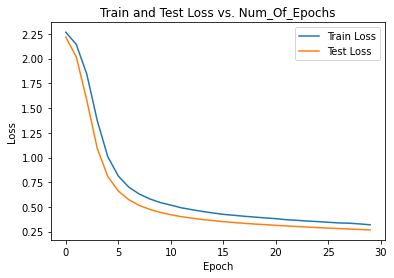

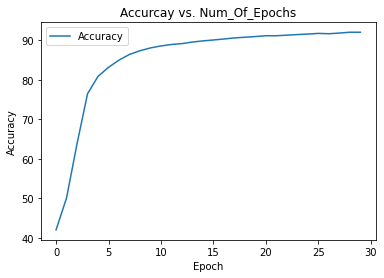

In [ ]:
# Move model to device
model.to(device)

train_losses = []
test_losses = []
accuracies = []
# Train the model
epochs = 30
for epoch in range(epochs):
    # train the model
    train_loss = train(model, device, train_dataloader, optimizer, loss_fn)
    train_losses.append(train_loss)
    # Evaluate the model
    test_loss, accuracy = test(model, device, test_dataloader, loss_fn)
    test_losses.append(test_loss)
    accuracies.append(accuracy)
    print(f"Epoch [{epoch+1}/{epochs}], train_loss: {train_loss:.4f}, test_loss: {test_loss:.4f}, accuracy: {accuracy:.2f}%")
    
# Finally, Evaluate the model
test_loss, accuracy = test(model, device, test_dataloader, loss_fn)
print(f"Test loss: {test_loss:.4f}, accuracy: {accuracy:.2f}%")

import matplotlib.pyplot as plt
# Plot the train loss and test loss
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), test_losses, label='Test Loss')
plt.title("Train and Test Loss vs. Num_Of_Epochs")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy
plt.plot(range(epochs), accuracies, label='Accuracy')
plt.title("Accurcay vs. Num_Of_Epochs")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show();

In [ ]:
stop

________________

# <center>Check The Performance for Different Parameter Values</center>

In [ ]:
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.options.display.width = 0

In [ ]:
#-----------------------------------------------------------------------------------------------------------------------------------
# Create an empty DataFrame
results_df = pd.DataFrame(columns=['train_loss', 'test_loss', 'accuracy', 'optimizer', 'no_of_epochs', 'batch_size'])

#-----------------------------------------------------------------------------------------------------------------------------------
# Create data loaders to batch and shuffle the data
# from torch.utils.data import DataLoader
# batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
batch_sizes=[16, 32, 64, 128, 256, 512]

#-----------------------------------------------------------------------------------------------------------------------------------
# Define the Neural Network Architecture
class Net_MNIST(nn.Module):
    def __init__(self):
        super(Net_MNIST,self).__init__()
        self.dropout_1 = nn.Dropout(0.1)
        self.dropout_2 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(in_features=784, out_features=256, bias=True)   # 1st Hidden layer
        self.fc2 = nn.Linear(256, 64)    # 4th Hidden layer
        self.fc3 = nn.Linear(64, 10)  #output layer

    def forward(self, x):
        x = x.view(-1, 784)  # Flatten input image
        x = torch.relu(self.fc1(x))  # add hidden layer, with relu activation function
        x = self.dropout_2(x)  # add dropout layer
        x = torch.relu(self.fc2(x))  # add hidden layer, with relu activation function
        x = self.dropout_1(x)
        x = self.fc3(x) # add output layer
        return x


#---------------------------------------------------------------------------------------------------------------------------------
# Instantiate the neural network model
model = Net_MNIST().to(device)
print(model)
#---------------------------------------------------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------------------------------------------
from tqdm import tqdm

def train(model, device, train_loader, optimizer, loss_fn):
    model.train()
    epoch_loss = 0.0
    with tqdm(total=len(train_loader)) as progress_bar:
        for i, (inputs, labels) in enumerate(train_loader, 0):
            inputs, labels = inputs.to(device), labels.to(device)

            # Compute prediction and loss
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            progress_bar.update(1)

    avg_epoch_loss = epoch_loss / len(train_loader)
    return avg_epoch_loss
#---------------------------------------------------------------------------------------------------------------------------------
def test(model, device, test_loader, loss_fn):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad(), tqdm(total=len(test_loader)) as progress_bar:
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            test_loss += loss_fn(outputs, labels).item() * labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            progress_bar.update(1)

    avg_test_loss = test_loss / len(test_loader.dataset)
    accuracy = 100 * correct / total
    return avg_test_loss, accuracy

#----------------------------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------------------
learning_rate = 1e-3
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()
# optimizer
optimizers = [torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9),torch.optim.Adam(model.parameters(), lr=0.001),
              torch.optim.Adagrad(model.parameters(), lr=0.01),optim.RMSprop(model.parameters(), lr=0.001)]
epochs_list = [20,40,60,80,100]
#---------------------------------------------------------------------------------------------------------------------------------

# Train the model
# Loop over optimizers
for i_optimizer in range(len(optimizers)):

    # iterate over different batch sizes
    for batch_size in batch_sizes:
        batch_size = batch_size

        # Loop over epochs
        for epochs in epochs_list:
            train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

            # Reset the weights and optimizer for each run
            model = Net_MNIST().to(device)
            for module in model.modules():
                """Reset the weights of a linear layer"""
                if isinstance(module, nn.Linear):
                    module.reset_parameters()

            # make optimizer instances
            # make optimizer instances
            optimizer_instance = [torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9),
                                  torch.optim.Adam(model.parameters(), lr=0.001),
                                  torch.optim.Adagrad(model.parameters(), lr=0.01),
                                  optim.RMSprop(model.parameters(), lr=0.001)][i_optimizer]
            optimizer_name = optimizer_instance.__class__.__name__        


            # Loop over each epoch and train the model
            for epoch in range(epochs):

                # train the model
                train_loss = train(model, device, train_dataloader, optimizer_instance, loss_fn)
                # Evaluate the model
                test_loss, accuracy = test(model, device, test_dataloader, loss_fn)
                print(f"Epoch [{epoch+1}/{epochs}], train_loss: {train_loss:.4f}, test_loss: {test_loss:.4f}, accuracy: {accuracy:.2f}%")
            
            # Evaluate the model after training and append results to the DataFrame
            test_loss, accuracy = test(model, device, test_dataloader, loss_fn)

            # Append results to dataframe
            results_df = results_df.append({'train_loss': train_loss,
                                            'test_loss': test_loss, 
                                            'accuracy': accuracy, 
                                            'optimizer': optimizer_name,
                                            'no_of_epochs': epochs, 
                                            'batch_size': batch_size}, ignore_index=True)
            
            print(f"Test loss: {test_loss:.4f}, accuracy: {accuracy:.2f}%")

            print(f"------- this was for epochs = {epochs}------now for next epoch------")
            print()
        print(f"-------This was for Batch Size: {batch_size}------- Now for next Batch Size-------")
        print()
    print(f"_____This was for optimizer: {optimizer_name} _______ now for next optimizer_____")
    print()


In [ ]:
# group the DataFrame by optimizer and batch size
grouped_df = results_df.groupby(['optimizer', 'batch_size'])

# apply the style to each group and concatenate the results
df_final = pd.concat([group.apply(lambda x: x.style.set_precision(2).background_gradient(cmap='coolwarm')) for name, group in grouped_df])

# display the styled DataFrame
df_final

In [ ]:
# save dataframe to excel file
df_final.to_excel('data.xlsx', index=False)

In [ ]:
import matplotlib.pyplot as plt

# Group the results by each parameter
grouped_results = results_df.groupby(['optimizer', 'no_of_epochs', 'batch_size'])

# Initialize the plot
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,8), sharey=True)

# Plot each result as a line in the corresponding subplot
for i, (param, group) in enumerate(grouped_results):
    ax = axes[i]
    for metric in ['accuracy', 'test_loss', 'train_loss']:
        ax.plot(group[param[0]], group[metric], label=metric)
    ax.set_xlabel(param[0])
    ax.set_title(f"{param[0]}={param[1]}, batch_size={param[2]}")
    ax.legend()

# Add a common y-axis label
fig.text(0.06, 0.5, 'Value', ha='center', va='center', rotation='vertical')

# Save the plot to disk
plt.savefig('my_figures.png', dpi=300)

# Show the plot
plt.show();

In [ ]:
#END